In [ ]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
from stock import Stock


In [ ]:
start = datetime.datetime(1928, 1, 1)
end = datetime.date.today()
spyData = Stock('^GSPC', start, end)
spyData.stockData = spyData.stockData.iloc[250:]

spyData.stockData.head()


,Close,Volume,MA20,MA60,MA120,MA250,EMA20,EMA60,EMA120,EMA250,MAScore,PriceScore,SumScore,Chg,%Chg
Date,,,,,,,,,,,,,,,
1929-01-02,24.81,0,23.1925,22.684667,21.405583,19.96540,23.444937,22.695886,21.731696,19.976027,100.0,100.0,100.0,0.46,1.89%
1929-01-03,24.86,0,23.2400,22.744667,21.454833,19.99396,23.579705,22.766841,21.783404,20.014943,100.0,100.0,100.0,0.05,0.2%
1929-01-04,24.85,0,23.2920,22.805167,21.505167,20.02316,23.700686,22.835141,21.834091,20.053470,100.0,100.0,100.0,-0.01,-0.04%
1929-01-07,24.25,0,23.3590,22.857500,21.549250,20.04952,23.753001,22.881530,21.874024,20.086908,100.0,100.0,100.0,-0.6,-2.41%
1929-01-08,24.17,0,23.4495,22.907333,21.594833,20.07620,23.792715,22.923775,21.911974,20.119443,100.0,100.0,100.0,-0.08,-0.33%


In [ ]:
class Period:
    def __init__(self):
        self.startIndex = None
        self.startDate = None
        self.startPrice = None
        self.endIndex = None
        self.endDate = None
        self.endPrice = None
        self.periodDays = None
        self.priceDiff = None

    def __str__(self):
        return "Bear period from {startIndex}-----{startDate}--{startPrice} $ to {endIndex}----{endDate}--{endPrice} $, period is {period} days and lost is {priceDiff} %".format(startIndex=self.startIndex, startDate=str(self.startDate)[0:10], startPrice=self.startPrice, endIndex=self.endIndex, endDate=str(self.endDate)[0:10], endPrice=self.endPrice, period=self.periodDays, priceDiff=self.priceDiff)

    def to_dis(self):
        return {
            'startIndex': self.startIndex,
            'startDate': self.startDate,
            'startPrice': self.startPrice,
            'endIndex': self.endIndex,
            'endDate': self.endDate,
            'endPrice': self.endPrice,
            'periodDays': self.periodDays,
            'priceDiff': self.priceDiff
        }


class ScoreAnalysis:
    def __init__(self, stock, priceScoreWeight=0.5, threshold=50) -> None:
        self.bearPeriod = []
        self.priceScoreWeight = priceScoreWeight
        self.threshold = threshold
        self.stock = stock.updateSumScore(priceScoreWeight)
        self.bearPeriodDF = None
        self.lostSum = None
        self.record = []

    def getBearPeriod(self):
        isbearPeriod = False
        for i in range(len(self.stock.stockData)):
            if not isbearPeriod:
                if self.stock.stockData.iloc[i]['SumScore'] < self.threshold:
                    isbearPeriod = True
                    newPeriod = Period()
                    newPeriod.startIndex = i
                    newPeriod.startDate = self.stock.stockData.index[i]
                    newPeriod.startPrice = self.stock.stockData.iloc[i]['Close']
                    self.bearPeriod.append(newPeriod)
                    continue
                else:
                    continue
            else:
                if self.stock.stockData.iloc[i]['SumScore'] >= self.threshold:
                    isbearPeriod = False
                    period = self.bearPeriod[-1]
                    period.endIndex = i
                    period.endDate = self.stock.stockData.index[i]
                    period.endPrice = self.stock.stockData.iloc[i]['Close']
                    period.periodDays = (
                        period.endDate - period.startDate).days
                    period.priceDiff = round(
                        (period.endPrice - period.startPrice)*100/period.startPrice, 2)
                    continue
                else:
                    continue

    def analysis(self):
        self.getBearPeriod()
        self.bearPeriodDF = pd.DataFrame.from_records(
            period.to_dis() for period in self.bearPeriod)
        self.lostSum = self.bearPeriodDF['priceDiff'].sum()

    def caculateIncome(self):
        initAmount = 10000
        shares = math.floor(
            initAmount/self.stock.stockData.iloc[0]['Close'])
        shareValue = shares * self.stock.stockData.iloc[0]['Close']
        initAmount = shareValue
        self.record.append({'Date': self.stock.stockData.index[0], 'action': 'buy', 'price': self.stock.stockData.iloc[
            0], 'shares': shares, 'shareValue': shareValue, 'earning': 0, 'earningRate': 0})
        i = 0
        while i < len(self.bearPeriod):
            period = self.bearPeriod[i]
            shareValue = shares*period.startPrice
            earning = shareValue-initAmount
            earningRate = earning*100/initAmount
            self.record.append({'Date': period.startDate, 'action': 'sell', 'price': period.startPrice,
                                'shares': shares, 'shareValue': shareValue, 'earning': earning, 'earningRate': earningRate})
            shares = math.floor(shareValue/period.endPrice)
            self.record.append({'Date': period.endDate, 'action': 'buy', 'price': period.endPrice,
                                'shares': shares, 'shareValue': shareValue, 'earning': earning, 'earningRate': earningRate})
            i=i+1
        shareValue = shares*self.stock.stockData.iloc[-1]['Close']
        earning = shareValue-initAmount
        earningRate = earning*100/initAmount
        self.record.append({'Date': self.stock.stockData.index[-1], 'action': 'sell', 'price': self.stock.stockData.iloc[-1]['Close'],
                            'shares': shares, 'shareValue': shareValue, 'earning': earning, 'earningRate': earningRate})
        self.recordDf= pd.DataFrame.from_records(record for record in scoreAnalysis.record)

In [ ]:
scoreAnalysis = ScoreAnalysis(spyData, 0.5, 40)
scoreAnalysis.analysis()
scoreAnalysis.caculateIncome()

In [ ]:
scoreAnalysis.bearPeriodDF.axes
scoreAnalysis.bearPeriodDF['priceDiff'].sum()
recordDf= pd.DataFrame.from_records(record for record in scoreAnalysis.record)
recordDf.tail()
print(spyData.stockData.iloc[-1]['Close']/spyData.stockData.iloc[0]['Close'])
print(recordDf.iloc[-1])

172.78557033454254
Date           2021-06-28 00:00:00
action                        sell
price                      4286.81
shares                         620
shareValue               2657822.2
earning                 2647823.77
earningRate           26482.395436
Name: 323, dtype: object


NameError: name 'bearPeriod' is not defined

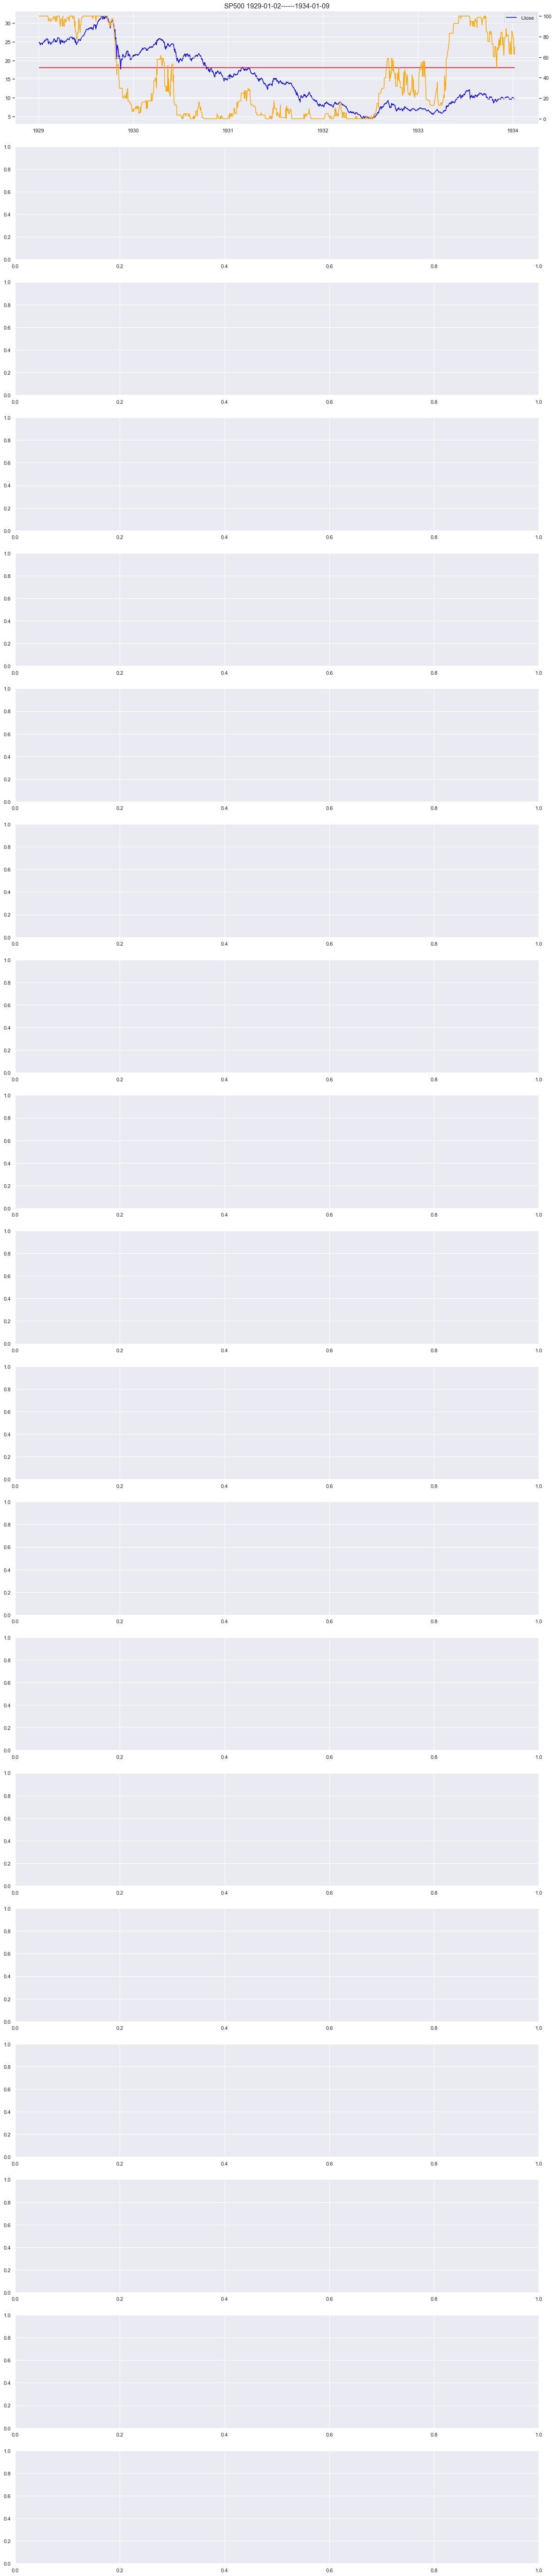

In [ ]:
fig, axes = plt.subplots(19, 1, figsize=(20, 100))
for i in range(19):
    data = spyData.stockData.iloc[i*1250:(i+1)*1250]
    axes[i].plot(data.index, data['Close'], label='Close', color='blue')
    axes[i].twinx()
    plt.plot(data.index, data['SumScore'], label='Score', color='orange')
    axes[i].legend()
    plt.hlines(y=50, xmin=data.index[0], xmax=data.index[-1], colors='red')
    plt.title("SP500 " + str(data.index[0])[0:10] +
              "------"+str(data.index[-1])[0:10], fontsize='large')
    startDate = data.index[0]
    endDate = data.index[-1]
    for period in bearPeriod:
        if period.startDate > startDate and period.startDate < endDate:
            plt.vlines(x=period.startDate, ymin=0, ymax=100, color='black')
        if period.endDate > startDate and period.endDate < endDate:
            plt.vlines(x=period.endDate, ymin=0, ymax=100, color='grey')


In [ ]:

increaseRate = 0.02
amount = 5000
Index = 0
cycle = 20
sharePrice = spyData.stockData.values[Index][0]
shares = round(amount/sharePrice)
shareValue = shares*sharePrice
ininData = [[spyData.stockData.index[Index], shareValue, 0, Index, sharePrice, 0,
             shares, shares, shareValue, shareValue, shareValue, sharePrice, 0, 0]]
dfValueAverage = pd.DataFrame(ininData, columns=['Date', 'TargetShareValue', 'ShareValueBeforePurchase', 'PriceIndex', 'SharePrice',  'newEarning', 'DeltaShare', 'Shares',
                                                 'PurchaseValue', 'ShareValue', 'Cost', 'ShareCost', 'Earning', 'EarningRate'])
index = dfValueAverage.iloc[0]['PriceIndex']


In [ ]:
dfValueAverage


,Date,TargetShareValue,ShareValueBeforePurchase,PriceIndex,SharePrice,newEarning,DeltaShare,Shares,PurchaseValue,ShareValue,Cost,ShareCost,Earning,EarningRate
0,1929-01-02,5011.62,0,0,24.81,0,202,202,5011.62,5011.62,5011.62,24.81,0,0


In [ ]:
i = 1
while Index < len(spyData.stockData)-cycle:
    previousData = dfValueAverage.iloc[i-1]
    Index = previousData['PriceIndex']+cycle
    currentSharePrice = spyData.stockData.values[Index][0]
    currentShareValueBeforePurchase = currentSharePrice*previousData['Shares']
    newEarning = currentShareValueBeforePurchase-previousData['ShareValue']
    targetShareValue = previousData['ShareValue']*(1+increaseRate)
    deltaShare = math.ceil(
        (targetShareValue-currentShareValueBeforePurchase)/currentSharePrice)
    currentShares = previousData['Shares']+deltaShare
    purchaceValue = deltaShare*currentSharePrice
    currentCost = previousData['Cost']+purchaceValue
    currentShareValue = currentShares*currentSharePrice
    currentEarning = currentShareValue-currentCost
    currentEarningRate = currentEarning*100/currentCost
    shareCost = currentCost/currentShares
    newData = [spyData.stockData.index[Index], targetShareValue, currentShareValueBeforePurchase, Index, currentSharePrice, newEarning, deltaShare, currentShares,
               purchaceValue, currentShareValue, currentCost, shareCost, currentEarning, currentEarningRate]
    dfValueAverage.loc[i] = newData
    i = i+1


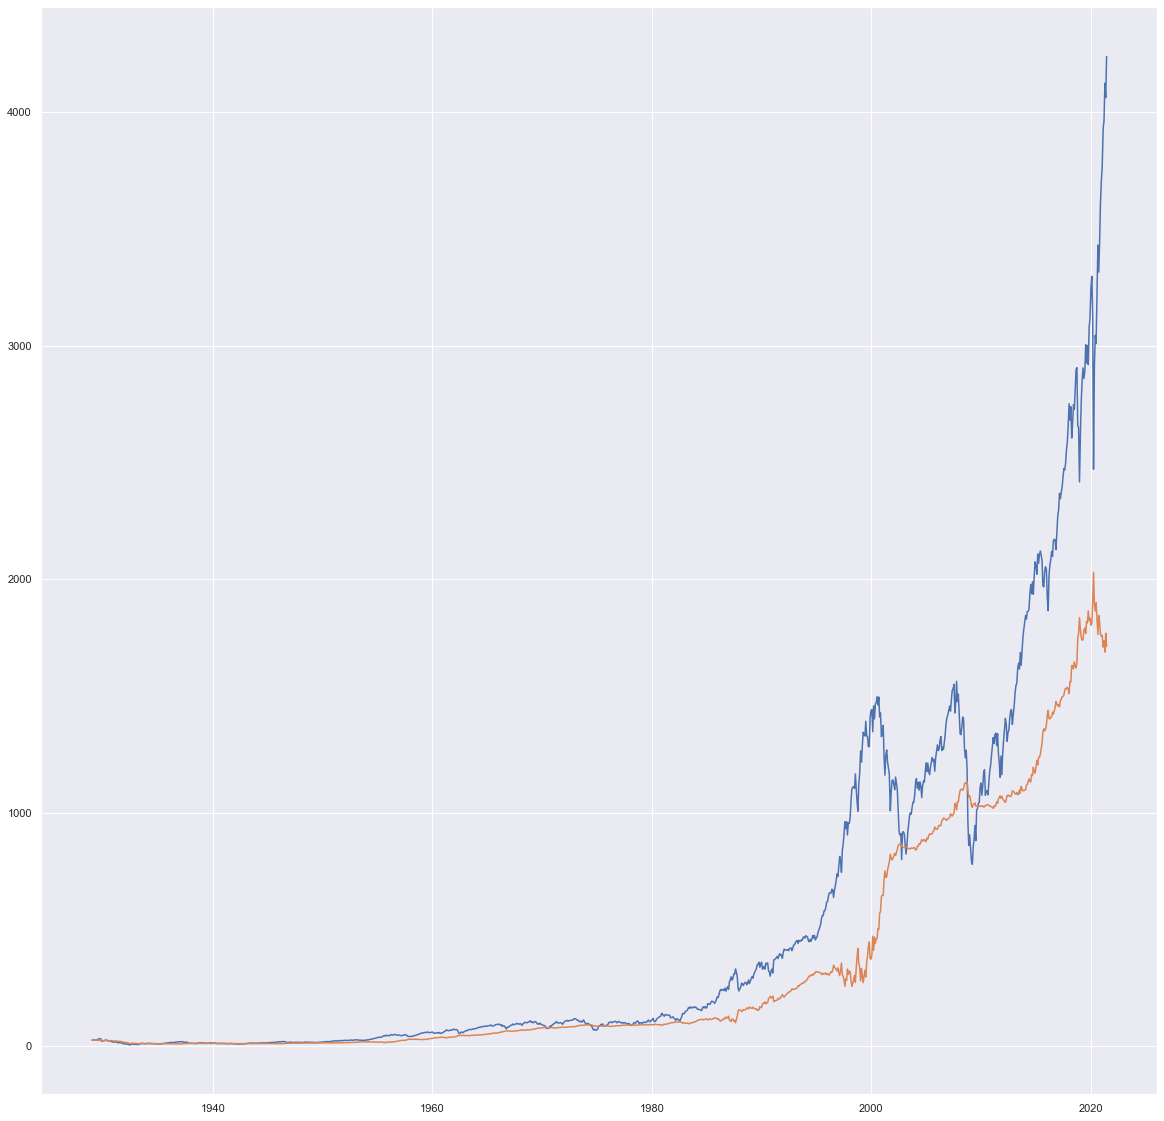

In [ ]:
plt.figure(figsize=(20, 20))
plt.plot(dfValueAverage['Date'], dfValueAverage['SharePrice'])
plt.plot(dfValueAverage['Date'], dfValueAverage['ShareCost'])


In [ ]:
increaseAmount = 600
Index = 0
cycle = 20
sharePrice = spyData.stockData.values[Index][0]
shares = math.ceil(increaseAmount/sharePrice)
shareValue = shares*sharePrice
ininData = [[spyData.stockData.index[Index],  0, Index, sharePrice, 0,
             shares, shares, shareValue, shareValue, shareValue, sharePrice, 0, 0]]
dfCurrencyAverage = pd.DataFrame(ininData, columns=['Date',  'ShareValueBeforePurchase', 'PriceIndex', 'SharePrice',  'newEarning', 'DeltaShare', 'Shares',
                                                    'PurchaseValue', 'ShareValue', 'Cost', 'ShareCost', 'Earning', 'EarningRate'])
index = dfCurrencyAverage.iloc[0]['PriceIndex']
dfCurrencyAverage


,Date,ShareValueBeforePurchase,PriceIndex,SharePrice,newEarning,DeltaShare,Shares,PurchaseValue,ShareValue,Cost,ShareCost,Earning,EarningRate
0,1929-01-02,0,0,24.81,0,25,25,620.25,620.25,620.25,24.81,0,0


In [ ]:
i = 1
while Index < len(spyData.stockData)-cycle:
    previousData = dfCurrencyAverage.iloc[i-1]
    Index = previousData['PriceIndex']+cycle
    currentSharePrice = spyData.stockData.values[Index][0]
    currentShareValueBeforePurchase = currentSharePrice*previousData['Shares']
    newEarning = currentShareValueBeforePurchase-previousData['ShareValue']
    deltaShare = math.ceil(increaseAmount/currentSharePrice)
    currentShares = previousData['Shares']+deltaShare
    purchaceValue = deltaShare*currentSharePrice
    currentCost = previousData['Cost']+purchaceValue
    currentShareValue = currentShares*currentSharePrice
    currentEarning = currentShareValue-currentCost
    currentEarningRate = currentEarning*100/currentCost
    shareCost = currentCost/currentShares
    newData = [spyData.stockData.index[Index],  currentShareValueBeforePurchase, Index, currentSharePrice, newEarning, deltaShare, currentShares,
               purchaceValue, currentShareValue, currentCost, shareCost, currentEarning, currentEarningRate]
    dfCurrencyAverage.loc[i] = newData
    i = i+1

dfCurrencyAverage


,Date,ShareValueBeforePurchase,PriceIndex,SharePrice,newEarning,DeltaShare,Shares,PurchaseValue,ShareValue,Cost,ShareCost,Earning,EarningRate
0,1929-01-02,0.00,0,24.81,0.00,25,25,620.25,620.25,620.25,24.810000,0.00,0.000000
1,1929-01-30,636.25,20,25.45,16.00,24,49,610.80,1247.05,1231.05,25.123469,16.00,1.299704
2,1929-03-01,1265.67,40,25.83,18.62,24,73,619.92,1885.59,1850.97,25.355753,34.62,1.870371
3,1929-04-01,1816.24,60,24.88,-69.35,25,98,622.00,2438.24,2472.97,25.234388,-34.73,-1.404384
4,1929-04-29,2501.94,80,25.53,63.70,24,122,612.72,3114.66,3085.69,25.292541,28.97,0.938850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,2021-02-16,72638869.89,23140,3932.59,3035524.14,1,18472,3932.59,72642802.48,1045458.21,56.596915,71597344.27,6848.417621
1158,2021-03-16,73199179.12,23160,3962.71,556376.64,1,18473,3962.71,73203141.83,1049420.92,56.808365,72153720.91,6875.574856
1159,2021-04-14,76194844.18,23180,4124.66,2991702.35,1,18474,4124.66,76198968.84,1053545.58,57.028558,75145423.26,7132.621947
1160,2021-05-12,75060600.96,23200,4063.04,-1138367.88,1,18475,4063.04,75064664.00,1057608.62,57.245392,74007055.38,6997.584360


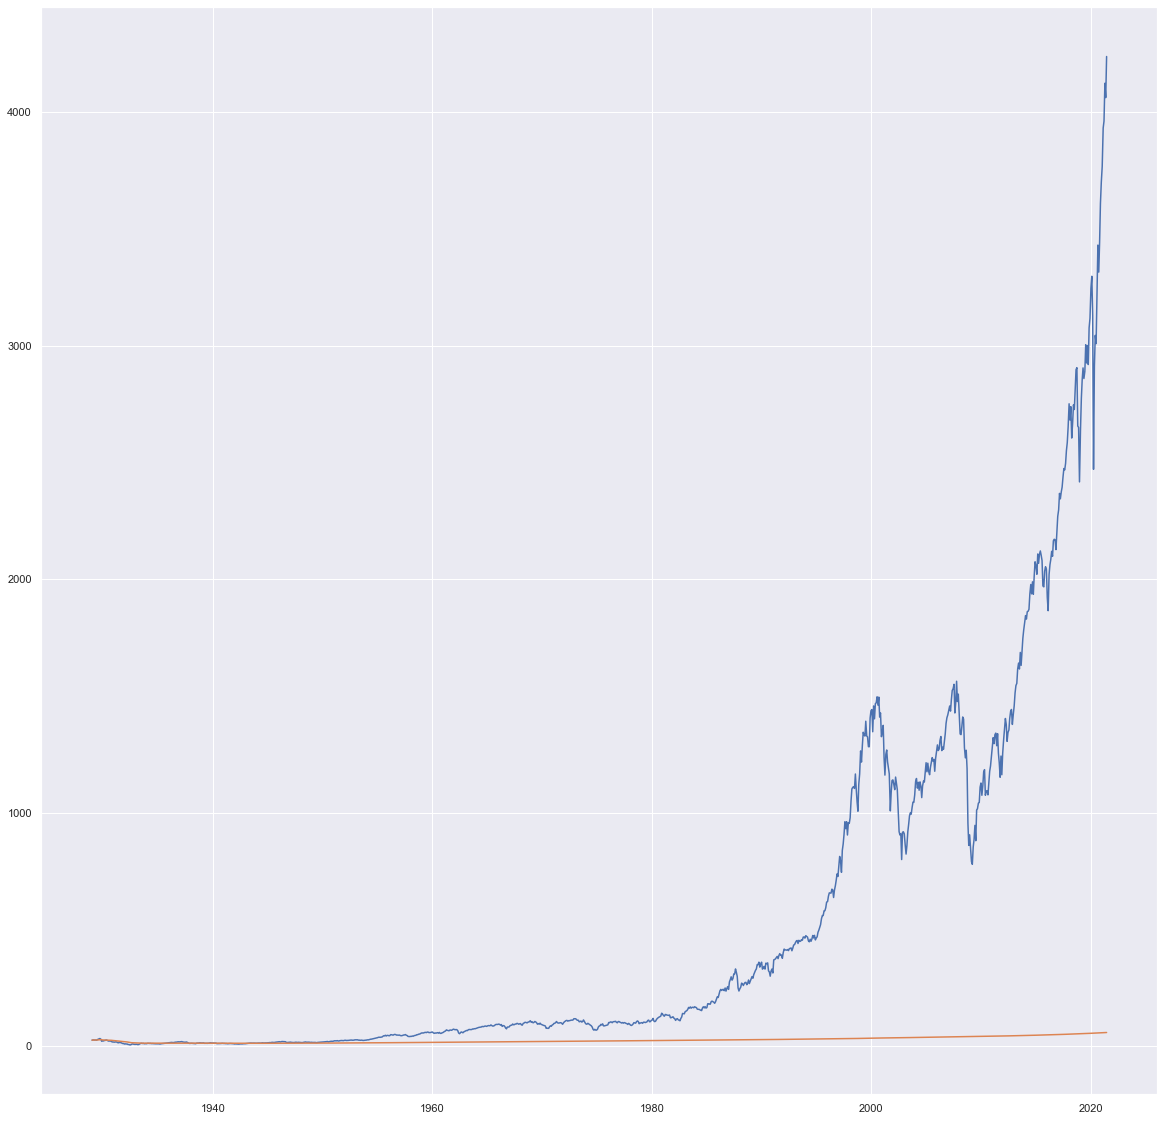

In [ ]:

plt.figure(figsize=(20, 20))
plt.plot(dfCurrencyAverage['Date'], dfCurrencyAverage['SharePrice'])
plt.plot(dfCurrencyAverage['Date'], dfCurrencyAverage['ShareCost'])


In [ ]:
start = datetime.datetime(1928, 1, 1)
end = datetime.date.today()
spyHis = web.DataReader('^GSPC', 'yahoo', start, end)[['Close']]
spyHis.head()


,Close
Date,
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000
1928-01-09,17.500000
